# Import Library

In [1]:
import os
import random
import shutil
import zipfile

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import (Dataset, DataLoader, random_split,
                              WeightedRandomSampler, ConcatDataset)
from torchvision.io import read_image
from torchvision.transforms import ToPILImage

# Understanding Dataset

In [2]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path file ZIP di Google Drive
zip_path = "/content/drive/MyDrive/datasets/DatasetUAS/bottle.zip"  # Ubah sesuai lokasi file kamu di Drive
extract_path = "/content/bottle"  # Ekstrak di Colab workspace

# Mengekstrak file ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset telah diekstrak ke: {extract_path}\n")

# (Opsional) Menampilkan isi folder hasil ekstraksi
print("Isi folder hasil ekstraksi:")
print(os.listdir(extract_path))

Mounted at /content/drive
Dataset telah diekstrak ke: /content/bottle

Isi folder hasil ekstraksi:
['license.txt', 'readme.txt', 'ground_truth', 'train', 'test']


In [3]:
extract_path = "bottle"

In [4]:
# Paths to dataset folders
ground_truth_path = os.path.join(extract_path, "ground_truth")
test_path = os.path.join(extract_path, "test")
train_path = os.path.join(extract_path, "train")

In [5]:
# Fungsi untuk menghitung jumlah file dalam setiap folder dan subfolder
def hitung_file_per_kategori(direktori):
    """Menghitung jumlah file dalam setiap subfolder pada sebuah direktori"""
    hasil = {}
    if os.path.exists(direktori):
        for subfolder in sorted(os.listdir(direktori)):
            subfolder_path = os.path.join(direktori, subfolder)
            if os.path.isdir(subfolder_path):
                jumlah_file = sum([len(files) for _, _, files in os.walk(subfolder_path)])
                hasil[subfolder] = jumlah_file
    return hasil

# Menghitung jumlah file dalam setiap kategori
ground_truth_counts = hitung_file_per_kategori(ground_truth_path)
test_counts = hitung_file_per_kategori(test_path)
train_counts = hitung_file_per_kategori(train_path)

# Menampilkan ringkasan dataset
print("📊 **Ringkasan Dataset:**")

# Menampilkan jumlah file dalam Ground Truth
print("\n📂 **Ground Truth**")
for kategori, jumlah in ground_truth_counts.items():
    print(f"   🗂️ {kategori}: {jumlah} file")

# Menampilkan jumlah file dalam Test Set
print("\n📂 **Test Set**")
for kategori, jumlah in test_counts.items():
    print(f"   🗂️ {kategori}: {jumlah} file")

# Menampilkan jumlah file dalam Train Set
print("\n📂 **Train Set**")
for kategori, jumlah in train_counts.items():
    print(f"   🗂️ {kategori}: {jumlah} file")

📊 **Ringkasan Dataset:**

📂 **Ground Truth**
   🗂️ broken_large: 20 file
   🗂️ broken_small: 22 file
   🗂️ contamination: 21 file

📂 **Test Set**
   🗂️ broken_large: 20 file
   🗂️ broken_small: 22 file
   🗂️ contamination: 21 file
   🗂️ good: 20 file

📂 **Train Set**
   🗂️ good: 209 file


# Data Pre-processing

1. Menggabungkan dataset test dan ground_truth ke dalam satu variabel train_data_combined.
2. Menghitung ulang jumlah file setelah kombinasi.
3. Menampilkan ringkasan dataset setelah perubahan.

In [6]:
combined_train_path = os.path.join("train_combined")

# Create new training folder
os.makedirs(combined_train_path, exist_ok=True)

# Copy files
def copy_files(src, dst):
    for category in os.listdir(src):
        src_path = os.path.join(src, category)
        dst_path = os.path.join(dst, category)
        if os.path.isdir(src_path):
            os.makedirs(dst_path, exist_ok=True)
            for file in os.listdir(src_path):
                shutil.copy2(os.path.join(src_path, file), os.path.join(dst_path, file))

copy_files(ground_truth_path, combined_train_path)
copy_files(test_path, combined_train_path)

In [7]:
# Count files
def count_files(directory):
    return {folder: len(os.listdir(os.path.join(directory, folder))) for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))}

train_combined_counts = count_files(combined_train_path)

# Output
print("\n📊 Dataset Setelah Digabung:")
for category, count in train_combined_counts.items():
    print(f"🗂️ {category}: {count} file")


📊 Dataset Setelah Digabung:
🗂️ contamination: 42 file
🗂️ broken_small: 44 file
🗂️ good: 20 file
🗂️ broken_large: 40 file


In [8]:
# Show structure
def show_structure(path, level=0):
    indent = "  " * level
    for item in sorted(os.listdir(path)):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            print(f"{indent}📂 {item}")
            show_structure(item_path, level + 1)
        else:
            print(f"{indent}📄 {item}")

print("\n📌 Struktur Dataset:")
show_structure("train_combined")


📌 Struktur Dataset:
📂 broken_large
  📄 000.png
  📄 000_mask.png
  📄 001.png
  📄 001_mask.png
  📄 002.png
  📄 002_mask.png
  📄 003.png
  📄 003_mask.png
  📄 004.png
  📄 004_mask.png
  📄 005.png
  📄 005_mask.png
  📄 006.png
  📄 006_mask.png
  📄 007.png
  📄 007_mask.png
  📄 008.png
  📄 008_mask.png
  📄 009.png
  📄 009_mask.png
  📄 010.png
  📄 010_mask.png
  📄 011.png
  📄 011_mask.png
  📄 012.png
  📄 012_mask.png
  📄 013.png
  📄 013_mask.png
  📄 014.png
  📄 014_mask.png
  📄 015.png
  📄 015_mask.png
  📄 016.png
  📄 016_mask.png
  📄 017.png
  📄 017_mask.png
  📄 018.png
  📄 018_mask.png
  📄 019.png
  📄 019_mask.png
📂 broken_small
  📄 000.png
  📄 000_mask.png
  📄 001.png
  📄 001_mask.png
  📄 002.png
  📄 002_mask.png
  📄 003.png
  📄 003_mask.png
  📄 004.png
  📄 004_mask.png
  📄 005.png
  📄 005_mask.png
  📄 006.png
  📄 006_mask.png
  📄 007.png
  📄 007_mask.png
  📄 008.png
  📄 008_mask.png
  📄 009.png
  📄 009_mask.png
  📄 010.png
  📄 010_mask.png
  📄 011.png
  📄 011_mask.png
  📄 012.png
  📄 012_m

# U-Net Model

1. Dataset Handling: Menggunakan Dataset dan DataLoader untuk memuat gambar dan mask.
2. Model U-Net: Arsitektur U-Net yang disesuaikan untuk segmentasi gambar.
3. Fungsi Loss & Dice Score: Menggunakan kombinasi BCEWithLogitsLoss dan Dice Score.
4. Training Loop: Proses pelatihan dengan validasi.
5. Evaluasi Model: Menghitung Dice Score pada set validasi.

## Dataset Handling

### Menyiapkan Data untuk Traininig

In [9]:
# Menentukan jalur dataset gabungan baru
train_data_path = "train_data"
os.makedirs(train_data_path, exist_ok=True)

# Fungsi untuk menyalin file ke satu folder
def copy_files_to_single_folder(src, dst):
    for category in os.listdir(src):
        src_path = os.path.join(src, category)
        if os.path.isdir(src_path):
            for file in os.listdir(src_path):
                file_src = os.path.join(src_path, file)
                file_dst = os.path.join(dst, file)
                shutil.copy2(file_src, file_dst)

# Menyalin semua file ke dalam folder train_data
copy_files_to_single_folder(ground_truth_path, train_data_path)
copy_files_to_single_folder(test_path, train_data_path)

print(f"✅ All images merged into '{train_data_path}'")

✅ All images merged into 'train_data'


In [10]:
# Menentukan jalur untuk folder gambar dan masker
images_path = os.path.join(train_data_path, "images")
masks_path = os.path.join(train_data_path, "masks")

# Membuat folder jika belum ada
os.makedirs(images_path, exist_ok=True)
os.makedirs(masks_path, exist_ok=True)

# Memindahkan file berdasarkan jenisnya
for file in os.listdir(train_data_path):
    file_path = os.path.join(train_data_path, file)

    if os.path.isfile(file_path):  # Memastikan ini adalah file, bukan folder
        if "mask" in file.lower():  # Mengasumsikan masker memiliki kata "mask" dalam nama file
            shutil.move(file_path, os.path.join(masks_path, file))
        else:
            shutil.move(file_path, os.path.join(images_path, file))

print("✅ Images and masks have been moved to separate folders.")

✅ Images and masks have been moved to separate folders.


In [11]:
# Count total files in each folder
total_images = len(os.listdir(images_path))
total_masks = len(os.listdir(masks_path))

# Print the total number of images and masks
print(f"✅ Data separation complete!")
print(f"🖼️ Total images: {total_images}")
print(f"🎭 Total masks: {total_masks}")

✅ Data separation complete!
🖼️ Total images: 22
🎭 Total masks: 22


### Data Transformation

In [12]:
# Transformasi khusus dengan sinkronisasi antara gambar dan masker
class SyncRandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, mask):
        if random.random() < self.p:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        return image, mask

class SyncRandomVerticalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, mask):
        if random.random() < self.p:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        return image, mask

class SyncRandomRotation:
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, image, mask):
        angle = random.uniform(-self.degrees, self.degrees)
        image = TF.rotate(image, angle)
        mask = TF.rotate(mask, angle)
        return image, mask

In [13]:
# Dataset yang ditingkatkan dengan transformasi yang tersinkronisasi**
class AnomalyDataset(Dataset):
    def __init__(self, images_dir, masks_dir, sync_transforms=None, image_transforms=None, mask_transforms=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))
        self.sync_transforms = sync_transforms
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Masker dalam skala abu-abu

        # Terapkan transformasi yang tersinkronisasi
        if self.sync_transforms:
            for t in self.sync_transforms:
                image, mask = t(image, mask)

        # Terapkan transformasi individu
        if self.image_transforms:
            image = self.image_transforms(image)
        if self.mask_transforms:
            mask = self.mask_transforms(mask)

        mask = (mask > 0.5).float()  # Konversi ke biner
        return image, mask

In [14]:
# Transformasi Sinkronisasi dan Individu**
sync_transforms = [
    SyncRandomHorizontalFlip(p=0.5),
    SyncRandomVerticalFlip(p=0.3),
    SyncRandomRotation(degrees=10),
]

image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Statistik ImageNet
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Memuat dataset dengan transformasi yang ditingkatkan
dataset = AnomalyDataset("train_data/images", "train_data/masks",
                        sync_transforms=sync_transforms,
                        image_transforms=image_transforms,
                        mask_transforms=mask_transforms)

### Train Split Data

In [15]:
# Menghitung ukuran split untuk dataset**
train_size = int(0.8 * len(dataset))  # Diubah dari 0.9 menjadi 0.8 untuk validasi yang lebih baik
val_size = len(dataset) - train_size

# Melakukan split dengan seed tetap untuk reproduktibilitas
train_dataset, val_dataset = random_split(dataset, [train_size, val_size],
                                          generator=torch.Generator().manual_seed(42))

# Membuat DataLoader dengan batch size lebih besar dan num_workers lebih banyak**
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## U-Net

1. DoubleConv: Blok konvolusi ganda dengan Batch Normalization, ReLU, dan opsi Dropout, serta koneksi residual jika jumlah channel input dan output sama.
2. UNet:
  - Downsampling: Menggunakan DoubleConv dan max pooling untuk mengurangi ukuran fitur.
  - Bottleneck: Lapisan tengah dengan konvolusi tambahan.
  - Upsampling: Menggunakan transposed convolution dan skip connections dari bagian downsampling untuk mempertahankan detail.
  - Final Convolution: Lapisan akhir untuk menghasilkan output segmentasi

In [16]:
# Improved U-Net dengan Residual Connections**
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, dropout_prob=0.0):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_prob),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_prob)
        )

        # Koneksi residual jika jumlah channel input dan output sama
        self.residual = nn.Identity() if in_channels == out_channels else \
                       nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        residual = self.residual(x)
        x = self.double_conv(x)
        return x + residual  # Menambahkan residual connection

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bagian downsampling dari U-Net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature, dropout_prob=0.1))
            in_channels = feature

        # Bottleneck (lapisan tengah)
        self.bottleneck = DoubleConv(features[-1], features[-1]*2, dropout_prob=0.2)

        # Bagian upsampling dari U-Net
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(
                DoubleConv(feature*2, feature, dropout_prob=0.1)
            )

        # Konvolusi akhir untuk menghasilkan output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        # Inisialisasi bobot
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        skip_connections = []

        # Bagian downsampling
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # Urutan dibalik untuk upsampling

        # Bagian upsampling
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # Upsample
            skip_connection = skip_connections[idx//2]

            # Menangani jika ukuran tidak sesuai
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)  # Double Conv

        return self.final_conv(x)

### Loss-Function

In [17]:
# Fungsi Loss yang Ditingkatkan**
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=1.5, smooth=1e-6):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)

        # Flatten tensor
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)

        # Menghitung true positives, false positives, false negatives
        tp = (inputs_flat * targets_flat).sum()
        fp = ((1-targets_flat) * inputs_flat).sum()
        fn = (targets_flat * (1-inputs_flat)).sum()

        # Menghitung indeks Tversky
        tversky = (tp + self.smooth) / (tp + self.alpha*fp + self.beta*fn + self.smooth)

        # Menerapkan modifikasi focal
        return (1 - tversky) ** self.gamma

# **Kombinasi Focal Tversky Loss dan Dice Loss**
class CombinedLoss(nn.Module):
    def __init__(self, focal_tversky_weight=0.7, dice_weight=0.3):
        super(CombinedLoss, self).__init__()
        self.focal_tversky = FocalTverskyLoss()
        self.dice = DiceLoss()
        self.focal_tversky_weight = focal_tversky_weight
        self.dice_weight = dice_weight

    def forward(self, preds, targets):
        focal_tversky_loss = self.focal_tversky(preds, targets)
        dice_loss = self.dice(preds, targets)
        return self.focal_tversky_weight * focal_tversky_loss + self.dice_weight * dice_loss

# **Fungsi Dice Loss untuk evaluasi segmentasi**
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, preds, targets, smooth=1e-6):
        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum()
        union = preds.sum() + targets.sum()
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice

# Inisialisasi Model dan Strategi Pelatihan yang Ditingkatkan**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = CombinedLoss().to(device)

# Menggunakan AdamW dengan weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Scheduler pembelajaran dengan Cosine Annealing dan Warm Restarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

# Fungsi Evaluasi Dice Score dengan Threshold yang Dapat Disesuaikan**
def dice_score(preds, targets, thresholds=None):
    if thresholds is None:
        thresholds = [0.5]  # Default threshold

    preds = torch.sigmoid(preds)
    best_dice = torch.tensor(0.0, device=preds.device)  # Inisialisasi sebagai tensor di device yang sama

    for threshold in thresholds:
        preds_binary = (preds > threshold).float()
        intersection = (preds_binary * targets).sum()
        union = preds_binary.sum() + targets.sum()
        dice = (2. * intersection) / (union + 1e-8)
        if dice > best_dice:
            best_dice = dice

    return best_dice.item()

## Train & Evaluation Model

In [18]:
# Loop Pelatihan yang Ditingkatkan dengan Gradient Accumulation**
num_epochs = 300  # Jumlah epoch ditingkatkan
scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())  # Gunakan AMP untuk percepatan komputasi
best_val_dice = 0
patience = 30  # Penyesuaian jumlah patience sebelum early stopping
counter = 0
best_model_path = 'best_unet_model.pth'
accumulation_steps = 2  # Jumlah langkah untuk gradient accumulation

# Membuat daftar threshold yang akan diuji
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_dice = 0
    optimizer.zero_grad()  # Reset gradien di awal epoch

    for i, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)

        with torch.amp.autocast(device_type=device.type, enabled=torch.cuda.is_available()):
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss = loss / accumulation_steps  # Normalisasi loss untuk akumulasi gradien

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        train_loss += loss.item() * accumulation_steps  # De-normalisasi untuk pelaporan
        train_dice += dice_score(outputs, masks, thresholds)

    # Menangani kasus jika batch terakhir tidak penuh
    if (i + 1) % accumulation_steps != 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    # Memperbarui learning rate
    scheduler.step()

    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = train_dice / len(train_loader)

    # **Validasi Model**
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=torch.cuda.is_available()):
                outputs = model(images)
                loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_dice += dice_score(outputs, masks, thresholds)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)

    # **Menyimpan Model Terbaik**
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': best_val_dice,
            },
            best_model_path
        )
        counter = 0
    else:
        counter += 1

    # **Early Stopping jika performa tidak meningkat dalam beberapa epoch**
    if counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {avg_train_loss:.4f} - Train Dice: {avg_train_dice:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} - Val Dice: {avg_val_dice:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.7f}")

# **Memuat Model Terbaik untuk Evaluasi**
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Training Selesai! Best validation Dice score: {best_val_dice:.4f} at epoch {checkpoint['epoch']+1}")

# **Evaluasi Akhir pada Set Validasi dengan Threshold Sweep**
model.eval()
val_dice = 0
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        val_dice += dice_score(outputs, masks, thresholds)

final_val_dice = val_dice / len(val_loader)
print(f"Final validation Dice score: {final_val_dice:.4f}")

Epoch 1/300 - Train Loss: 0.8371 - Train Dice: 0.1501 | Val Loss: 0.6812 - Val Dice: 0.2953 | LR: 0.0004878
Epoch 2/300 - Train Loss: 0.7730 - Train Dice: 0.2119 | Val Loss: 0.6401 - Val Dice: 0.3348 | LR: 0.0004523
Epoch 3/300 - Train Loss: 0.7493 - Train Dice: 0.2331 | Val Loss: 0.6136 - Val Dice: 0.3593 | LR: 0.0003972
Epoch 4/300 - Train Loss: 0.6281 - Train Dice: 0.3395 | Val Loss: 0.6149 - Val Dice: 0.3579 | LR: 0.0003276
Epoch 5/300 - Train Loss: 0.5918 - Train Dice: 0.3703 | Val Loss: 0.6182 - Val Dice: 0.3552 | LR: 0.0002505
Epoch 6/300 - Train Loss: 0.6926 - Train Dice: 0.2819 | Val Loss: 0.5923 - Val Dice: 0.3790 | LR: 0.0001734
Epoch 7/300 - Train Loss: 0.5882 - Train Dice: 0.3785 | Val Loss: 0.6045 - Val Dice: 0.3682 | LR: 0.0001038
Epoch 8/300 - Train Loss: 0.6731 - Train Dice: 0.3024 | Val Loss: 0.6156 - Val Dice: 0.3581 | LR: 0.0000487
Epoch 9/300 - Train Loss: 0.5558 - Train Dice: 0.4086 | Val Loss: 0.5997 - Val Dice: 0.3726 | LR: 0.0000132
Epoch 10/300 - Train Loss: 0

## Test Prediction

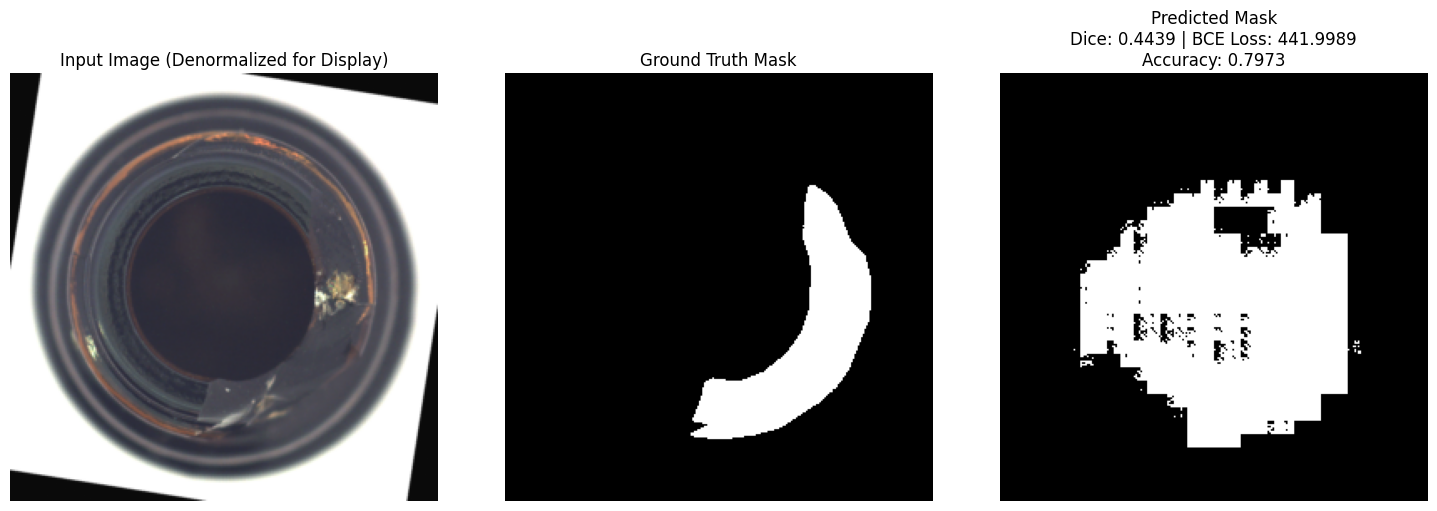

Image 1 Raw tensor range: [-1.9295..2.6400]
Image 1 Denormalized tensor range: [0.0431..1.0000]
Image 1 Accuracy: 0.7973


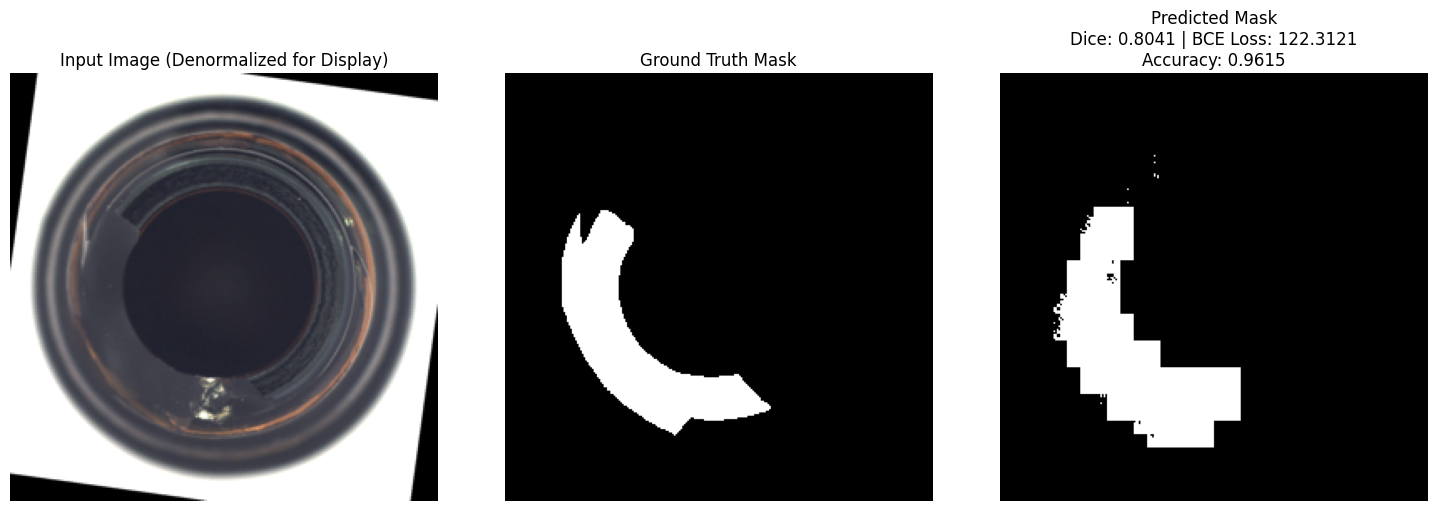

Image 2 Raw tensor range: [-2.1179..2.6400]
Image 2 Denormalized tensor range: [0.0000..1.0000]
Image 2 Accuracy: 0.9615


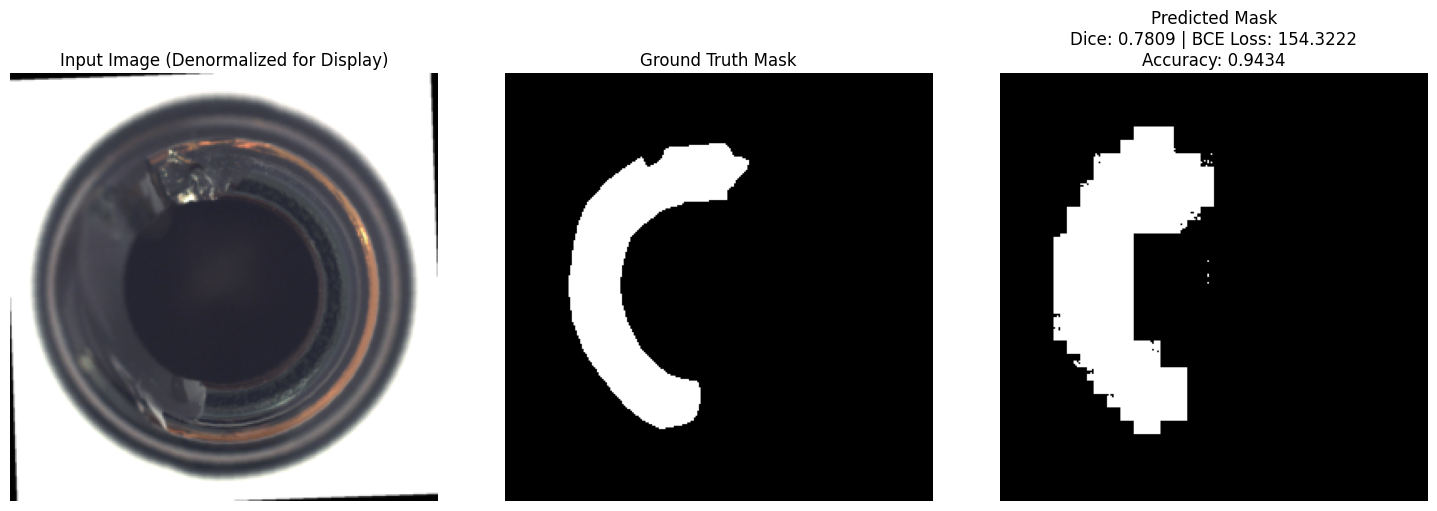

Image 3 Raw tensor range: [-2.0665..2.6400]
Image 3 Denormalized tensor range: [0.0118..1.0000]
Image 3 Accuracy: 0.9434


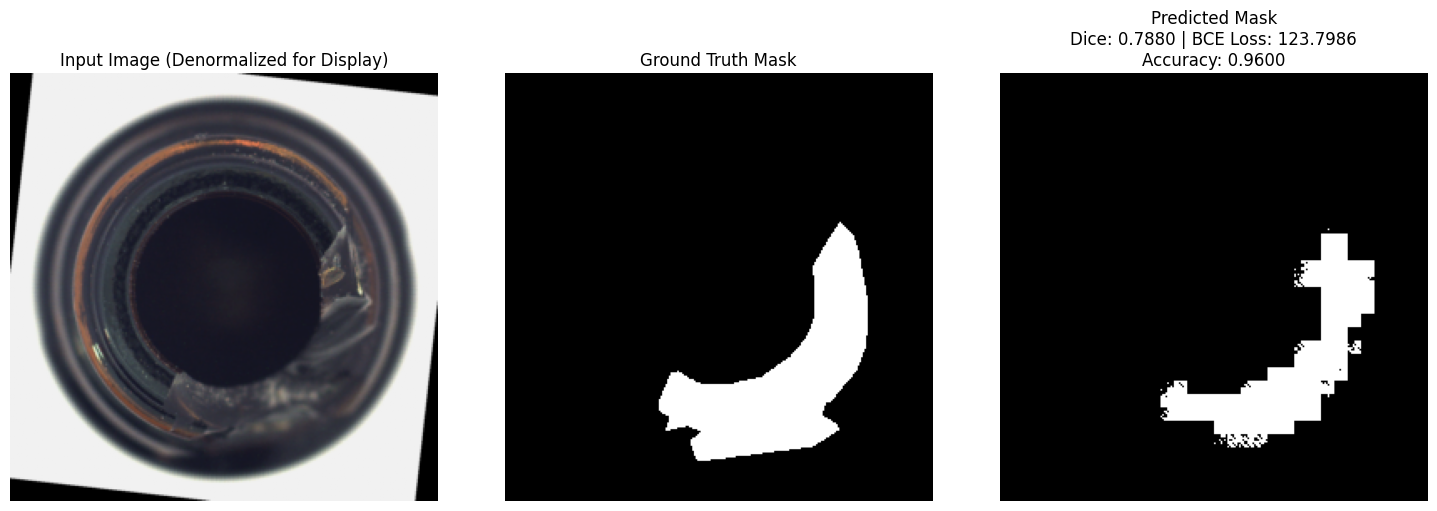

Image 4 Raw tensor range: [-2.1179..2.3960]
Image 4 Denormalized tensor range: [0.0000..0.9451]
Image 4 Accuracy: 0.9600


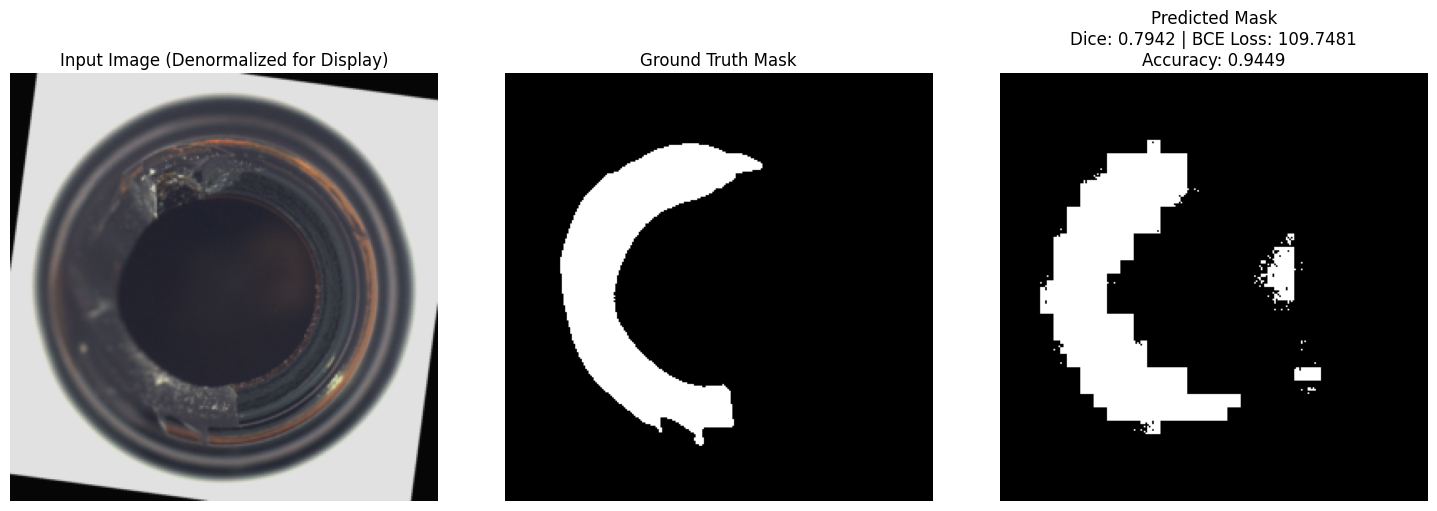

Image 5 Raw tensor range: [-1.9980..2.1171]
Image 5 Denormalized tensor range: [0.0275..0.8824]
Image 5 Accuracy: 0.9449


In [19]:
def dice_score(pred, target):
    smooth = 1.0
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2.0 * intersection + smooth) / (union + smooth)

def compute_accuracy(pred_bin, target):
    """Calculate pixel-wise accuracy"""
    correct = (pred_bin == target).float().sum()
    total = target.numel()
    return correct / total

# ImageNet normalization parameters
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def denormalize_imagenet(tensor):
    """Denormalize using ImageNet stats"""
    device = tensor.device  # Get tensor's current device
    mean = torch.tensor(imagenet_mean, device=device).view(3, 1, 1)
    std = torch.tensor(imagenet_std, device=device).view(3, 1, 1)
    return tensor * std + mean

# Switch model to evaluation mode
model.eval()
with torch.no_grad():
    image_count = 0  # Melacak jumlah gambar yang diproses
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        for i in range(images.shape[0]):   # Memproses batch secara bertahap
            if image_count >= 5:  # Berhenti setelah menguji 5 gambar
                break

            preds = torch.sigmoid(outputs[i])
            preds_bin = (preds > 0.5).float()

            img_raw = images[i].cpu().clone()
            img_denorm = denormalize_imagenet(images[i]).cpu()
            img_vis = img_denorm.permute(1, 2, 0).numpy().clip(0, 1)
            mask = masks[i].cpu().squeeze().numpy()
            pred = preds_bin.cpu().squeeze().numpy()

            # Compute metrics
            dice = dice_score(outputs[i], masks[i]).item()
            bce_loss = F.binary_cross_entropy_with_logits(outputs[i], masks[i]).item()
            accuracy = compute_accuracy(preds_bin, masks[i]).item()

            # Plot the results
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(img_vis)
            ax[0].set_title("Input Image (Denormalized for Display)")
            ax[0].axis("off")

            ax[1].imshow(mask, cmap="gray")
            ax[1].set_title("Ground Truth Mask")
            ax[1].axis("off")

            ax[2].imshow(pred, cmap="gray")
            ax[2].set_title(f"Predicted Mask\nDice: {dice:.4f} | BCE Loss: {bce_loss:.4f}\nAccuracy: {accuracy:.4f}")
            ax[2].axis("off")

            plt.tight_layout()
            plt.show()

            # ✅ Debugging prints
            print(f"Image {image_count + 1} Raw tensor range: [{img_raw.min().item():.4f}..{img_raw.max().item():.4f}]")
            print(f"Image {image_count + 1} Denormalized tensor range: [{img_denorm.min().item():.4f}..{img_denorm.max().item():.4f}]")
            print(f"Image {image_count + 1} Accuracy: {accuracy:.4f}")

            image_count += 1
            if image_count >= 5:
                break

Total images in dataset: 5


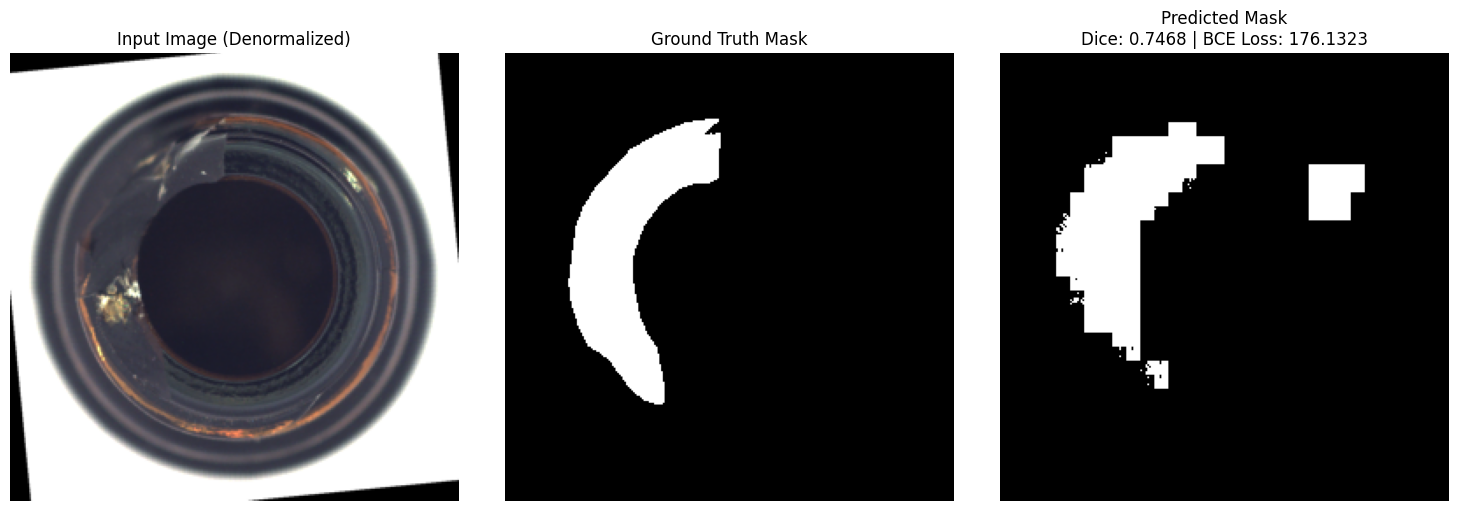

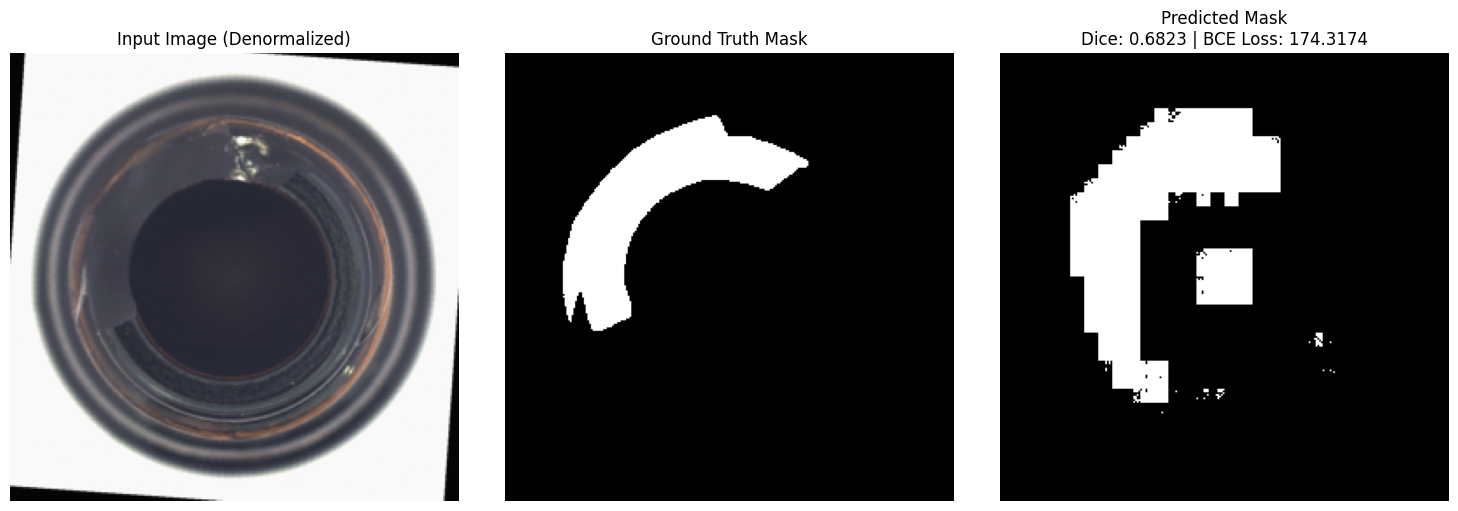

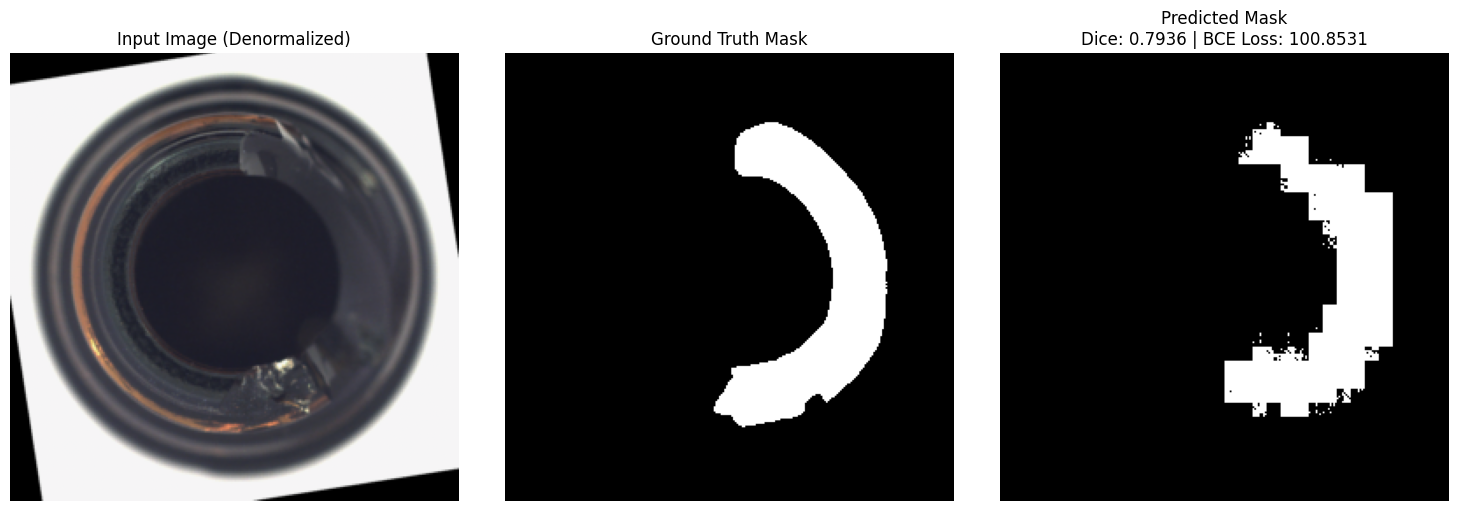

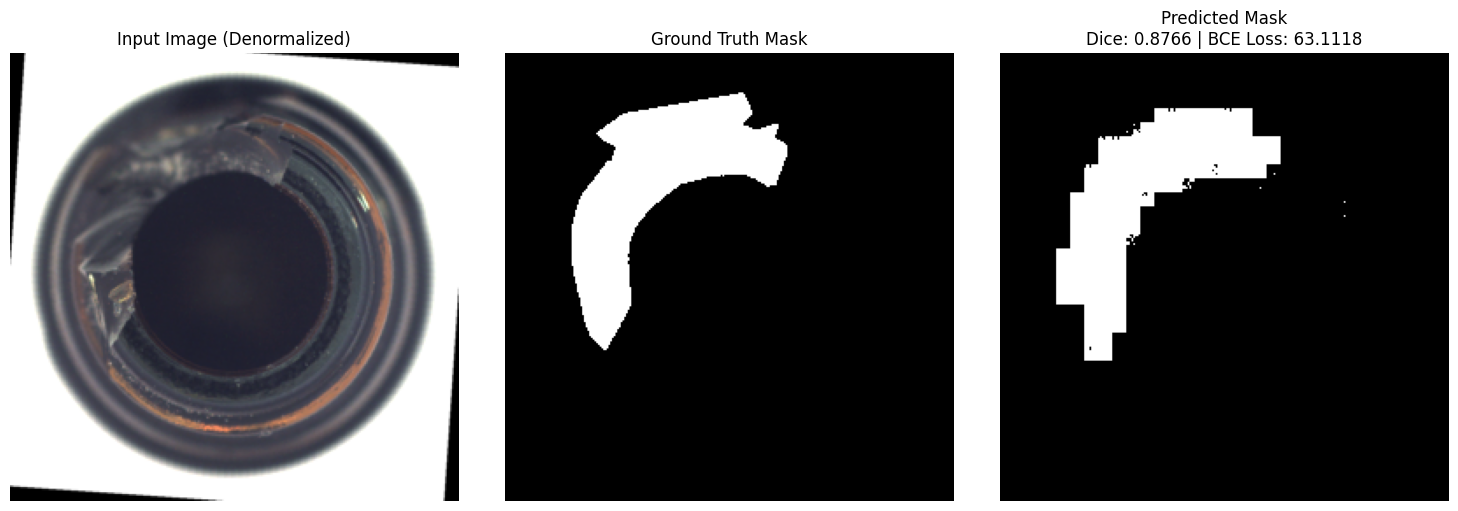

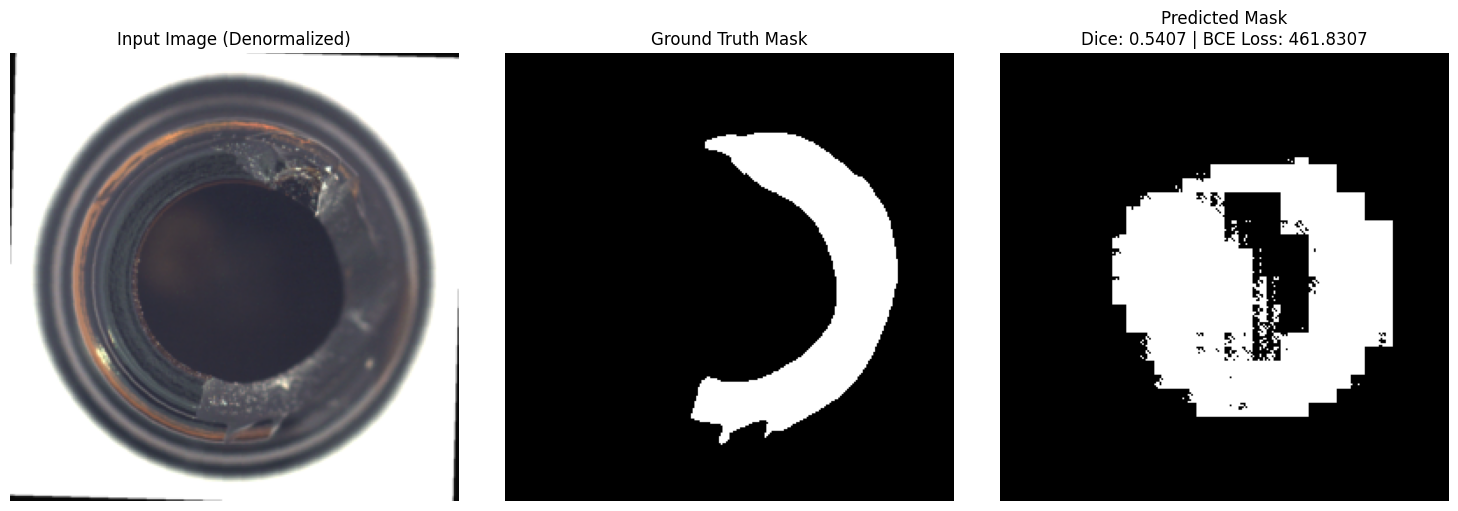

Total Samples: 5
Overall Accuracy: 1.0000


In [20]:
def dice_score(pred, target):
    smooth = 1.0
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2.0 * intersection + smooth) / (union + smooth)

def compute_accuracy(pred_bin, target):
    """Calculate sample-level accuracy for anomaly detection.

    Accuracy is 1 if:
    - Anomaly exists in ground truth and is detected in prediction.
    - No anomaly in ground truth and no detection in prediction.

    Otherwise, accuracy is 0.
    """
    pred_has_anomaly = pred_bin.sum() > 0  # True if prediction contains any anomaly
    target_has_anomaly = target.sum() > 0  # True if ground truth contains any anomaly

    return float(pred_has_anomaly == target_has_anomaly)  # 1 if correct, 0 otherwise


# ImageNet normalization parameters
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def denormalize_imagenet(tensor):
    """Denormalize using ImageNet stats"""
    device = tensor.device  # Get tensor's current device
    mean = torch.tensor(imagenet_mean, device=device).view(3, 1, 1)
    std = torch.tensor(imagenet_std, device=device).view(3, 1, 1)
    return tensor * std + mean


# Switch model to evaluation mode
model.eval()
total_correct = 0  # Track total correct anomaly detections
total_samples = 0  # Track total test samples

with torch.no_grad():
    for images, masks in val_loader:
        print(f"Total images in dataset: {len(val_loader.dataset)}")
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        for i in range(images.shape[0]):  # Loop through batch
            preds = torch.sigmoid(outputs[i])
            preds_bin = (preds > 0.5).float()

            # Compute sample-level anomaly accuracy
            correct = compute_accuracy(preds_bin, masks[i])
            total_correct += correct  # Accumulate correct predictions
            total_samples += 1  # Increment sample count

            # Optional: Visualization
            if total_samples <= 5:  # Only visualize first 5 images
                img_denorm = denormalize_imagenet(images[i]).cpu()
                img_vis = img_denorm.permute(1, 2, 0).numpy().clip(0, 1)
                mask = masks[i].cpu().squeeze().numpy()
                pred = preds_bin.cpu().squeeze().numpy()

                # Compute metrics
                dice = dice_score(outputs[i], masks[i]).item()
                bce_loss = F.binary_cross_entropy_with_logits(outputs[i], masks[i]).item()

                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(img_vis)
                ax[0].set_title("Input Image (Denormalized)")
                ax[0].axis("off")

                ax[1].imshow(mask, cmap="gray")
                ax[1].set_title("Ground Truth Mask")
                ax[1].axis("off")

                ax[2].imshow(pred, cmap="gray")
                ax[2].set_title(f"Predicted Mask\nDice: {dice:.4f} | BCE Loss: {bce_loss:.4f}")
                ax[2].axis("off")

                plt.tight_layout()
                plt.show()

# Compute overall accuracy
overall_accuracy = total_correct / total_samples

print(f"Total Samples: {total_samples}")
print(f"Overall Accuracy: {overall_accuracy:.4f}")

In [21]:
# ✅ Save the model after training
torch.save(model.state_dict(), "unet_model.pth")
print("✅ Model saved successfully!")

✅ Model saved successfully!


In [22]:
torch.save(model, "unet_model_full.pth")
print("✅ Full model saved!")

✅ Full model saved!


## Testing

In [23]:
def load_model(model_path="unet_model.pth", device=None):
    """
    Loads the U-Net model with only weights.

    Args:
        model_path (str): Path to the saved model weights.
        device (str or torch.device): Device to load the model on.

    Returns:
        torch.nn.Module: Loaded U-Net model.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ✅ Initialize the U-Net model
    model = UNet(in_channels=3, out_channels=1)

    # ✅ Load weights only
    model.load_state_dict(torch.load(model_path, map_location=device))

    model.to(device)
    model.eval()

    return model, device

# Load the U-Net model
model, device = load_model()

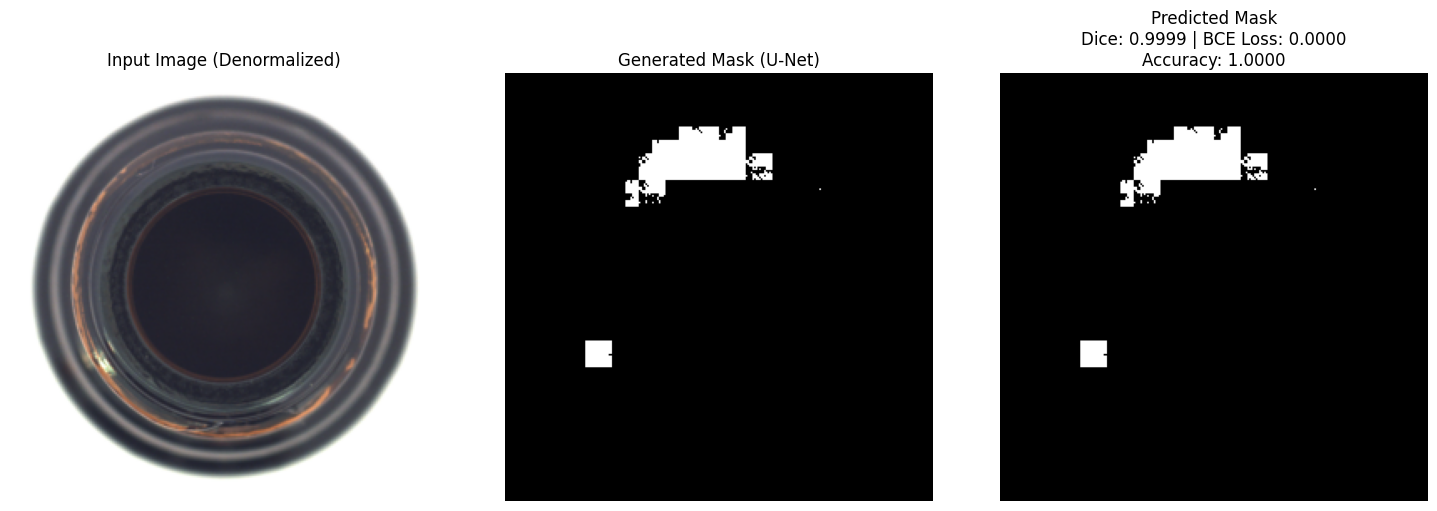

Dice Score: 0.9999
BCE Loss: 0.0000
Accuracy: 1.0000


In [24]:
# Define dice score function
def dice_score(pred, target):
    smooth = 1.0
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2.0 * intersection + smooth) / (union + smooth)

# Compute accuracy function
def compute_accuracy(pred_bin, target):
    pred_has_anomaly = pred_bin.sum() > 0
    target_has_anomaly = target.sum() > 0
    return float(pred_has_anomaly == target_has_anomaly)

# ImageNet normalization parameters
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def denormalize_imagenet(tensor):
    device = tensor.device
    mean = torch.tensor(imagenet_mean, device=device).view(3, 1, 1)
    std = torch.tensor(imagenet_std, device=device).view(3, 1, 1)
    return tensor * std + mean

# Load manual image
def load_image(image_path, image_size=(256, 256)):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Generate mask using U-Net model
def generate_mask(model, image):
    with torch.no_grad():
        output = model(image)
        mask = torch.sigmoid(output)
        mask_bin = (mask > 0.5).float()
    return mask_bin

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model (Ensure model is already loaded)
model.eval()

# Provide manual image path
image_path = "/content/bottle/test/good/019.png"

# Load image
image = load_image(image_path)
image = image.to(device)

# Generate mask using U-Net model
mask = generate_mask(model, image)

# Run inference with no gradient tracking
with torch.no_grad():
    output = model(image)
    pred = torch.sigmoid(output[0])
    pred_bin = (pred > 0.5).float()

    # Compute metrics
    dice = dice_score(output[0], mask[0]).item()
    bce_loss = F.binary_cross_entropy_with_logits(output[0], mask[0]).item()
    accuracy = compute_accuracy(pred_bin, mask[0])

    # Visualization
    img_denorm = denormalize_imagenet(image[0]).cpu()
    img_vis = img_denorm.permute(1, 2, 0).numpy().clip(0, 1)
    mask_vis = mask[0].cpu().squeeze().numpy()
    pred_vis = pred_bin.cpu().squeeze().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img_vis)
    ax[0].set_title("Input Image (Denormalized)")
    ax[0].axis("off")

    ax[1].imshow(mask_vis, cmap="gray")
    ax[1].set_title("Generated Mask (U-Net)")
    ax[1].axis("off")

    ax[2].imshow(pred_vis, cmap="gray")
    ax[2].set_title(f"Predicted Mask\nDice: {dice:.4f} | BCE Loss: {bce_loss:.4f}\nAccuracy: {accuracy:.4f}")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

print(f"Dice Score: {dice:.4f}")
print(f"BCE Loss: {bce_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

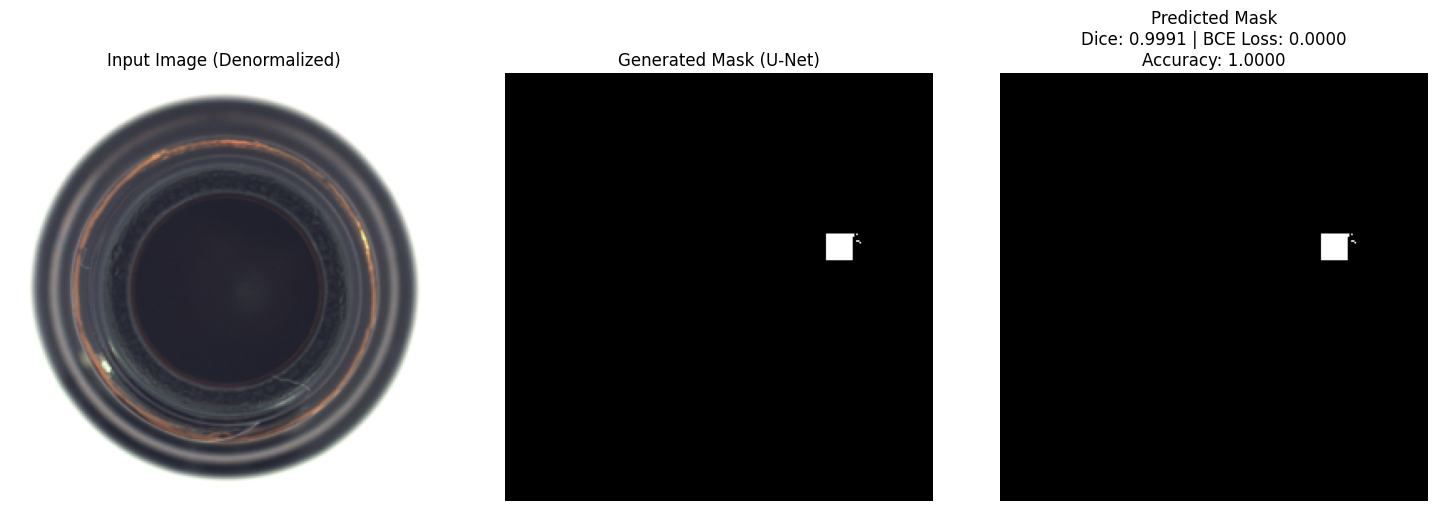

Dice Score: 0.9991
BCE Loss: 0.0000
Accuracy: 1.0000


In [25]:
# Define dice score function
def dice_score(pred, target):
    smooth = 1.0
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2.0 * intersection + smooth) / (union + smooth)

# Compute accuracy function
def compute_accuracy(pred_bin, target):
    pred_has_anomaly = pred_bin.sum() > 0
    target_has_anomaly = target.sum() > 0
    return float(pred_has_anomaly == target_has_anomaly)

# ImageNet normalization parameters
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def denormalize_imagenet(tensor):
    device = tensor.device
    mean = torch.tensor(imagenet_mean, device=device).view(3, 1, 1)
    std = torch.tensor(imagenet_std, device=device).view(3, 1, 1)
    return tensor * std + mean

# Load manual image
def load_image(image_path, image_size=(256, 256)):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Generate mask using U-Net model
def generate_mask(model, image):
    with torch.no_grad():
        output = model(image)
        mask = torch.sigmoid(output)
        mask_bin = (mask > 0.5).float()
    return mask_bin

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model (Ensure model is already loaded)
model.eval()

# Provide manual image path
image_path = "/content/bottle/test/good/001.png"

# Load image
image = load_image(image_path)
image = image.to(device)

# Generate mask using U-Net model
mask = generate_mask(model, image)

# Run inference with no gradient tracking
with torch.no_grad():
    output = model(image)
    pred = torch.sigmoid(output[0])
    pred_bin = (pred > 0.5).float()

    # Compute metrics
    dice = dice_score(output[0], mask[0]).item()
    bce_loss = F.binary_cross_entropy_with_logits(output[0], mask[0]).item()
    accuracy = compute_accuracy(pred_bin, mask[0])

    # Visualization
    img_denorm = denormalize_imagenet(image[0]).cpu()
    img_vis = img_denorm.permute(1, 2, 0).numpy().clip(0, 1)
    mask_vis = mask[0].cpu().squeeze().numpy()
    pred_vis = pred_bin.cpu().squeeze().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img_vis)
    ax[0].set_title("Input Image (Denormalized)")
    ax[0].axis("off")

    ax[1].imshow(mask_vis, cmap="gray")
    ax[1].set_title("Generated Mask (U-Net)")
    ax[1].axis("off")

    ax[2].imshow(pred_vis, cmap="gray")
    ax[2].set_title(f"Predicted Mask\nDice: {dice:.4f} | BCE Loss: {bce_loss:.4f}\nAccuracy: {accuracy:.4f}")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

print(f"Dice Score: {dice:.4f}")
print(f"BCE Loss: {bce_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

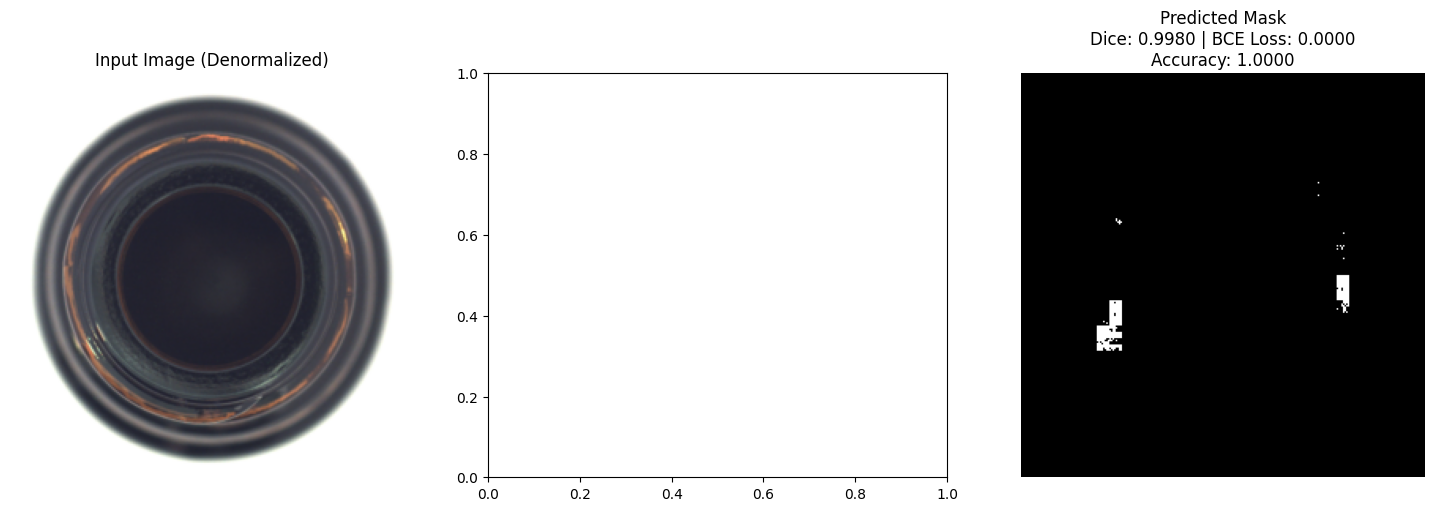

Dice Score: 0.9980
BCE Loss: 0.0000
Accuracy: 1.0000


In [26]:
# Define dice score function
def dice_score(pred, target):
    smooth = 1.0
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2.0 * intersection + smooth) / (union + smooth)

# Compute accuracy function
def compute_accuracy(pred_bin, target):
    pred_has_anomaly = pred_bin.sum() > 0
    target_has_anomaly = target.sum() > 0
    return float(pred_has_anomaly == target_has_anomaly)

# ImageNet normalization parameters
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def denormalize_imagenet(tensor):
    device = tensor.device
    mean = torch.tensor(imagenet_mean, device=device).view(3, 1, 1)
    std = torch.tensor(imagenet_std, device=device).view(3, 1, 1)
    return tensor * std + mean

# Load manual image
def load_image(image_path, image_size=(256, 256)):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Generate mask using U-Net model
def generate_mask(model, image):
    with torch.no_grad():
        output = model(image)
        mask = torch.sigmoid(output)
        mask_bin = (mask > 0.5).float()
    return mask_bin

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model (Ensure model is already loaded)
model.eval()

# Provide manual image path
image_path = "/content/bottle/test/good/000.png"

# Load image
image = load_image(image_path)
image = image.to(device)

# Generate mask using U-Net model
mask = generate_mask(model, image)

# Run inference with no gradient tracking
with torch.no_grad():
    output = model(image)
    pred = torch.sigmoid(output[0])
    pred_bin = (pred > 0.5).float()

    # Compute metrics
    dice = dice_score(output[0], mask[0]).item()
    bce_loss = F.binary_cross_entropy_with_logits(output[0], mask[0]).item()
    accuracy = compute_accuracy(pred_bin, mask[0])

    # Visualization
    img_denorm = denormalize_imagenet(image[0]).cpu()
    img_vis = img_denorm.permute(1, 2, 0).numpy().clip(0, 1)
    mask_vis = mask[0].cpu().squeeze().numpy()
    pred_vis = pred_bin.cpu().squeeze().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img_vis)
    ax[0].set_title("Input Image (Denormalized)")
    ax[0].axis("off")

    ax[2].imshow(pred_vis, cmap="gray")
    ax[2].set_title(f"Predicted Mask\nDice: {dice:.4f} | BCE Loss: {bce_loss:.4f}\nAccuracy: {accuracy:.4f}")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

print(f"Dice Score: {dice:.4f}")
print(f"BCE Loss: {bce_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

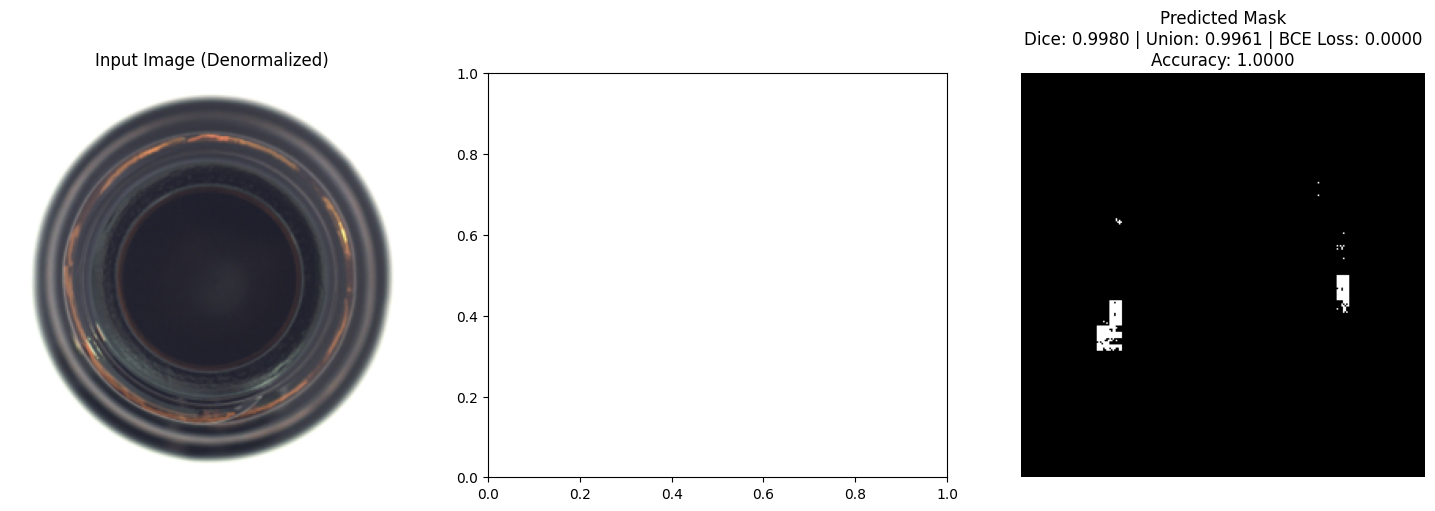

Dice Score: 0.9980
Union Score: 0.9961
BCE Loss: 0.0000
Accuracy: 1.0000


In [27]:
# Define dice score function
def dice_score(pred, target):
    smooth = 1.0
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2.0 * intersection + smooth) / (union + smooth)

# Define union score function
def union_score(pred, target):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return intersection / (union + 1e-6)  # Avoid division by zero

# Compute accuracy function
def compute_accuracy(pred_bin, target):
    pred_has_anomaly = pred_bin.sum() > 0
    target_has_anomaly = target.sum() > 0
    return float(pred_has_anomaly == target_has_anomaly)

# ImageNet normalization parameters
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def denormalize_imagenet(tensor):
    device = tensor.device
    mean = torch.tensor(imagenet_mean, device=device).view(3, 1, 1)
    std = torch.tensor(imagenet_std, device=device).view(3, 1, 1)
    return tensor * std + mean

# Load manual image
def load_image(image_path, image_size=(256, 256)):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Generate mask using U-Net model
def generate_mask(model, image):
    with torch.no_grad():
        output = model(image)
        mask = torch.sigmoid(output)
        mask_bin = (mask > 0.5).float()
    return mask_bin

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model (Ensure model is already loaded)
model.eval()

# Provide manual image path
image_path = "/content/bottle/test/good/000.png"

# Load image
image = load_image(image_path)
image = image.to(device)

# Generate mask using U-Net model
mask = generate_mask(model, image)

# Run inference with no gradient tracking
with torch.no_grad():
    output = model(image)
    pred = torch.sigmoid(output[0])
    pred_bin = (pred > 0.5).float()

    # Compute metrics
    dice = dice_score(output[0], mask[0]).item()
    union = union_score(output[0], mask[0]).item()
    bce_loss = F.binary_cross_entropy_with_logits(output[0], mask[0]).item()
    accuracy = compute_accuracy(pred_bin, mask[0])

    # Visualization
    img_denorm = denormalize_imagenet(image[0]).cpu()
    img_vis = img_denorm.permute(1, 2, 0).numpy().clip(0, 1)
    mask_vis = mask[0].cpu().squeeze().numpy()
    pred_vis = pred_bin.cpu().squeeze().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img_vis)
    ax[0].set_title("Input Image (Denormalized)")
    ax[0].axis("off")

    ax[2].imshow(pred_vis, cmap="gray")
    ax[2].set_title(f"Predicted Mask\nDice: {dice:.4f} | Union: {union:.4f} | BCE Loss: {bce_loss:.4f}\nAccuracy: {accuracy:.4f}")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

print(f"Dice Score: {dice:.4f}")
print(f"Union Score: {union:.4f}")
print(f"BCE Loss: {bce_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")


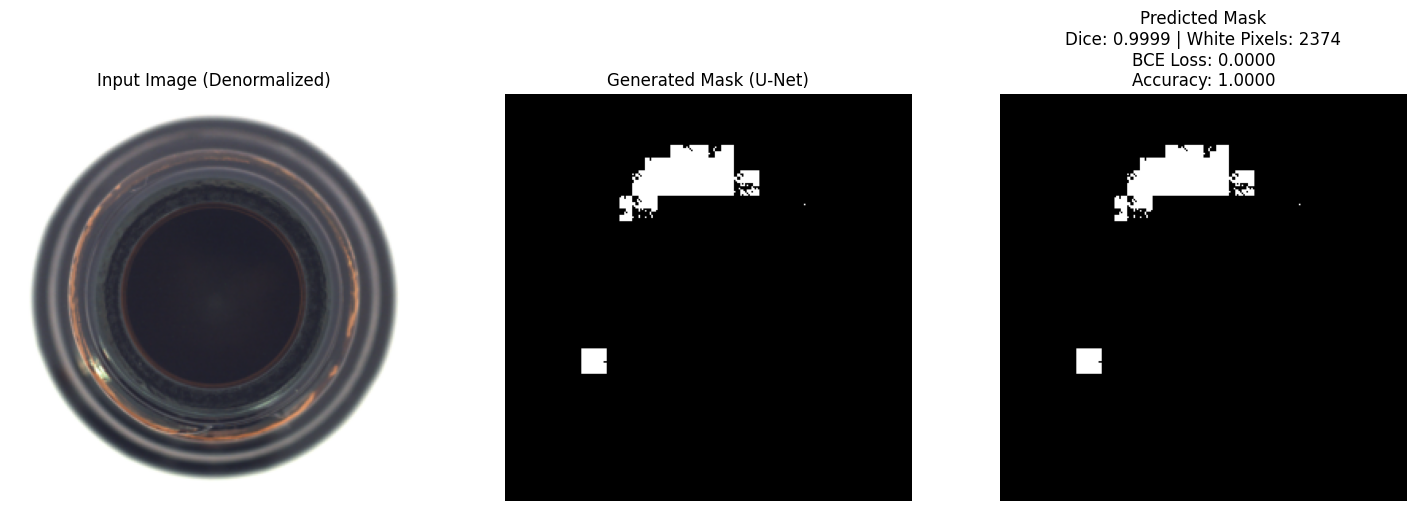

Dice Score: 0.9999
White Pixels Count: 2374
BCE Loss: 0.0000
Accuracy: 1.0000


In [28]:
# Define dice score function
def dice_score(pred, target):
    smooth = 1.0
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2.0 * intersection + smooth) / (union + smooth)

# Count white pixels in prediction
def count_white_pixels(pred):
    return (pred > 0.5).sum().item()

# Compute accuracy function
def compute_accuracy(pred_bin, target):
    pred_has_anomaly = pred_bin.sum() > 0
    target_has_anomaly = target.sum() > 0
    return float(pred_has_anomaly == target_has_anomaly)

# ImageNet normalization parameters
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def denormalize_imagenet(tensor):
    device = tensor.device
    mean = torch.tensor(imagenet_mean, device=device).view(3, 1, 1)
    std = torch.tensor(imagenet_std, device=device).view(3, 1, 1)
    return tensor * std + mean

# Load manual image
def load_image(image_path, image_size=(256, 256)):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Generate mask using U-Net model
def generate_mask(model, image):
    with torch.no_grad():
        output = model(image)
        mask = torch.sigmoid(output)
        mask_bin = (mask > 0.5).float()
    return mask_bin

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model (Ensure model is already loaded)
model.eval()

# Provide manual image path
image_path = "/content/bottle/test/good/019.png"

# Load image
image = load_image(image_path)
image = image.to(device)

# Generate mask using U-Net model
mask = generate_mask(model, image)

# Run inference with no gradient tracking
with torch.no_grad():
    output = model(image)
    pred = torch.sigmoid(output[0])
    pred_bin = (pred > 0.5).float()

    # Compute metrics
    dice = dice_score(output[0], mask[0]).item()
    white_pixel_count = count_white_pixels(pred_bin)
    bce_loss = F.binary_cross_entropy_with_logits(output[0], mask[0]).item()
    accuracy = compute_accuracy(pred_bin, mask[0])

    # Visualization
    img_denorm = denormalize_imagenet(image[0]).cpu()
    img_vis = img_denorm.permute(1, 2, 0).numpy().clip(0, 1)
    mask_vis = mask[0].cpu().squeeze().numpy()
    pred_vis = pred_bin.cpu().squeeze().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img_vis)
    ax[0].set_title("Input Image (Denormalized)")
    ax[0].axis("off")

    ax[1].imshow(mask_vis, cmap="gray")
    ax[1].set_title("Generated Mask (U-Net)")
    ax[1].axis("off")

    ax[2].imshow(pred_vis, cmap="gray")
    ax[2].set_title(f"Predicted Mask\nDice: {dice:.4f} | White Pixels: {white_pixel_count}\nBCE Loss: {bce_loss:.4f}\nAccuracy: {accuracy:.4f}")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

print(f"Dice Score: {dice:.4f}")
print(f"White Pixels Count: {white_pixel_count}")
print(f"BCE Loss: {bce_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

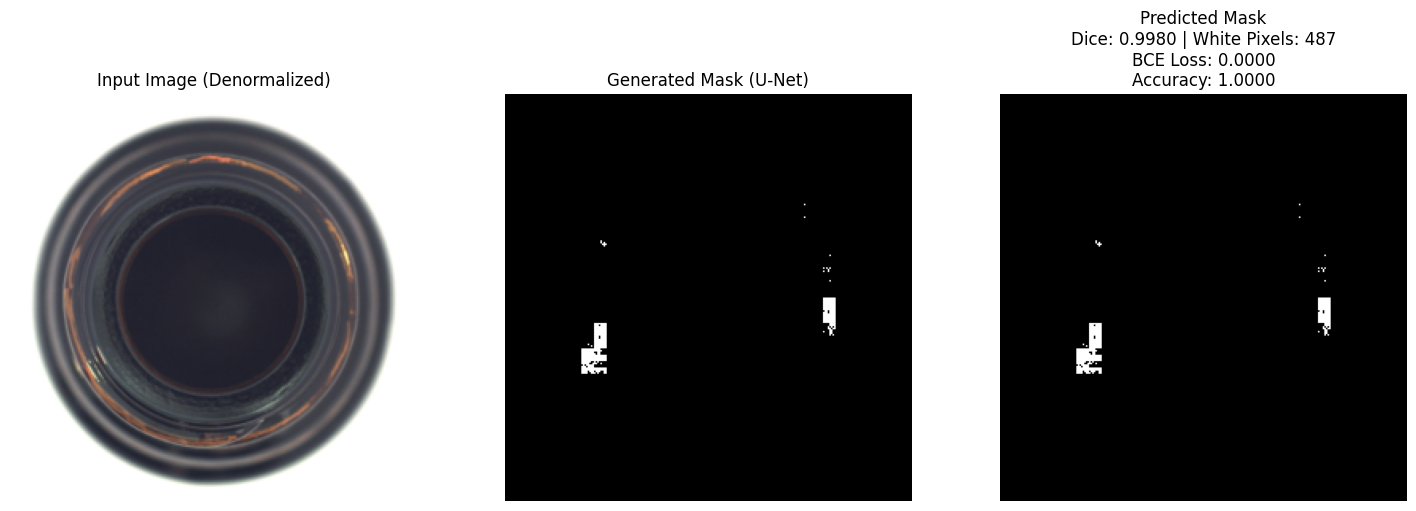

Dice Score: 0.9980
White Pixels Count: 487
BCE Loss: 0.0000
Accuracy: 1.0000


In [29]:
# Define dice score function
def dice_score(pred, target):
    smooth = 1.0
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2.0 * intersection + smooth) / (union + smooth)

# Count white pixels in prediction
def count_white_pixels(pred):
    return (pred > 0.5).sum().item()

# Compute accuracy function
def compute_accuracy(pred_bin, target):
    pred_has_anomaly = pred_bin.sum() > 0
    target_has_anomaly = target.sum() > 0
    return float(pred_has_anomaly == target_has_anomaly)

# ImageNet normalization parameters
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def denormalize_imagenet(tensor):
    device = tensor.device
    mean = torch.tensor(imagenet_mean, device=device).view(3, 1, 1)
    std = torch.tensor(imagenet_std, device=device).view(3, 1, 1)
    return tensor * std + mean

# Load manual image
def load_image(image_path, image_size=(256, 256)):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Generate mask using U-Net model
def generate_mask(model, image):
    with torch.no_grad():
        output = model(image)
        mask = torch.sigmoid(output)
        mask_bin = (mask > 0.5).float()
    return mask_bin

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model (Ensure model is already loaded)
model.eval()

# Provide manual image path
image_path = "/content/bottle/test/good/000.png"

# Load image
image = load_image(image_path)
image = image.to(device)

# Generate mask using U-Net model
mask = generate_mask(model, image)

# Run inference with no gradient tracking
with torch.no_grad():
    output = model(image)
    pred = torch.sigmoid(output[0])
    pred_bin = (pred > 0.5).float()

    # Compute metrics
    dice = dice_score(output[0], mask[0]).item()
    white_pixel_count = count_white_pixels(pred_bin)
    bce_loss = F.binary_cross_entropy_with_logits(output[0], mask[0]).item()
    accuracy = compute_accuracy(pred_bin, mask[0])

    # Visualization
    img_denorm = denormalize_imagenet(image[0]).cpu()
    img_vis = img_denorm.permute(1, 2, 0).numpy().clip(0, 1)
    mask_vis = mask[0].cpu().squeeze().numpy()
    pred_vis = pred_bin.cpu().squeeze().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img_vis)
    ax[0].set_title("Input Image (Denormalized)")
    ax[0].axis("off")

    ax[1].imshow(mask_vis, cmap="gray")
    ax[1].set_title("Generated Mask (U-Net)")
    ax[1].axis("off")

    ax[2].imshow(pred_vis, cmap="gray")
    ax[2].set_title(f"Predicted Mask\nDice: {dice:.4f} | White Pixels: {white_pixel_count}\nBCE Loss: {bce_loss:.4f}\nAccuracy: {accuracy:.4f}")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

print(f"Dice Score: {dice:.4f}")
print(f"White Pixels Count: {white_pixel_count}")
print(f"BCE Loss: {bce_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")